In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [2]:
stock = yf.Ticker("AAPL")
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False)

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2015-01-02 00:00:00-05:00,27.847500,27.860001,26.837500,27.332500,24.320436,212818400,0.0,0.0
2015-01-05 00:00:00-05:00,27.072500,27.162500,26.352501,26.562500,23.635286,257142000,0.0,0.0
2015-01-06 00:00:00-05:00,26.635000,26.857500,26.157499,26.565001,23.637512,263188400,0.0,0.0
2015-01-07 00:00:00-05:00,26.799999,27.049999,26.674999,26.937500,23.968962,160423600,0.0,0.0
2015-01-08 00:00:00-05:00,27.307501,28.037500,27.174999,27.972500,24.889906,237458000,0.0,0.0


In [4]:
ts = data['Close']

In [5]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF մոդել (Statsmodels):')
    print(f'ADF վիճակագրություն: {result[0]}')
    print(f'p-արժեք: {result[1]}')
    print('Կրիտիկական արժեքներ:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("\nԱրդյունք: Շարքը հավանաբար ստացիոնար է (մերժում ենք null հիպոթեզը)")
    else:
        print("\nԱրդյունք: Շարքը հավանաբար ստացիոնար չէ (չենք մերժում null հիպոթեզը)")

adf_test(ts)

ADF մոդել (Statsmodels):
ADF վիճակագրություն: 0.7277025813295473
p-արժեք: 0.99037481330067
Կրիտիկական արժեքներ:
	1%: -3.4329527780962255
	5%: -2.8626898965523724
	10%: -2.567382133955709

Արդյունք: Շարքը հավանաբար ստացիոնար չէ (չենք մերժում null հիպոթեզը)


In [6]:
# Ինչպես տեսաք ADF թեստի արդյունքում, փակման գների շարքը ստացիոնար չէ (p-արժեքը մեծ է 0.05-ից),
# ինչը բնորոշ է թրենդ ունեցող շարքերին։ 

In [7]:
ts_diff = ts.diff().dropna()

In [8]:
adf_test(ts_diff)

ADF մոդել (Statsmodels):
ADF վիճակագրություն: -15.833994606078928
p-արժեք: 9.867827785980093e-29
Կրիտիկական արժեքներ:
	1%: -3.4329631791044304
	5%: -2.8626944896608433
	10%: -2.5673845793841457

Արդյունք: Շարքը հավանաբար ստացիոնար է (մերժում ենք null հիպոթեզը)


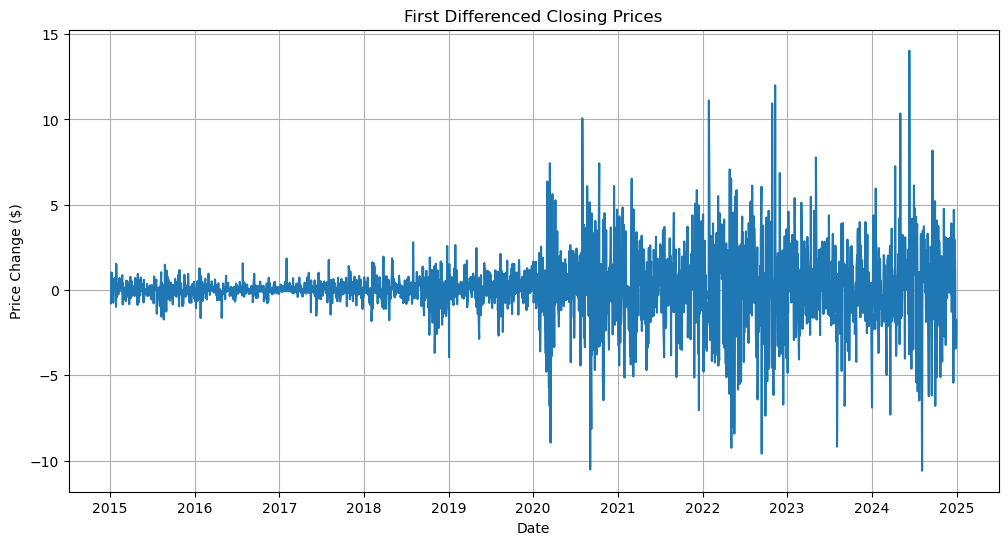

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(ts_diff)
plt.title('First Differenced Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price Change ($)')
plt.grid(True)
plt.show()

In [10]:
#  Լավագույն (p, q) պարամետրերի որոշում auto_arima-ի միջոցով
# auto_arima-ն ավտոմատ փորձում է տարբեր p, d, q համակցություններ և ընտրում լավագույնը
# ըստ որևէ չափանիշի (օրինակ՝ AIC կամ BIC): Մենք արդեն որոշեցինք d=1, բայց auto_arima-ն
# կարող է նաև ինքնուրույն որոշել d-ն, եթե մենք չսահմանենք:

In [11]:
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[0:train_size], ts[train_size:]

In [12]:
print(f"Մարզման տվյալների չափը: {len(train_data)}")
print(f"Թեստավորման տվյալների չափը: {len(test_data)}")

Մարզման տվյալների չափը: 2012
Թեստավորման տվյալների չափը: 504


In [13]:
auto_model = pm.auto_arima(train_data,
                           start_p=0, start_q=0,
                           max_p=5, max_q=5, # Փորձել p-ի և q-ի տարբեր արժեքներ մինչև 5
                           d=None, # Թույլ տալ auto_arima-ին ինքնուրույն որոշել d-ն
                           seasonal=False, # Ոչ սեզոնային մոդել
                           stepwise=True,
                           suppress_warnings=True,
                           error_action='ignore')


In [14]:
print(f"\nauto_arima-ի կողմից ընտրված լավագույն ARIMA կարգը (p, d, q): {auto_model.order}")


auto_arima-ի կողմից ընտրված լավագույն ARIMA կարգը (p, d, q): (0, 1, 1)


In [15]:
p, d, q = auto_model.order

In [16]:
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -4008.786
Date:                Mon, 28 Apr 2025   AIC                           8021.572
Time:                        15:27:33   BIC                           8032.785
Sample:                             0   HQIC                          8025.688
                               - 2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0568      0.013     -4.498      0.000      -0.082      -0.032
sigma2         3.1550      0.047     66.622      0.000       3.062       3.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4274.22
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              42.57   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
start_index = len(train_data)
end_index = len(ts) - 1 

In [19]:
predictions = model_fit.forecast(steps=len(test_data))

/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [20]:
predictions.index = test_data.index

In [21]:
print("Կանխատեսումներն ավարտված են:")
print(predictions.head())
print("...")
print(predictions.tail())

Կանխատեսումներն ավարտված են:
Date
2022-12-29 00:00:00-05:00    126.272575
2022-12-30 00:00:00-05:00    126.272575
2023-01-03 00:00:00-05:00    126.272575
2023-01-04 00:00:00-05:00    126.272575
2023-01-05 00:00:00-05:00    126.272575
Name: predicted_mean, dtype: float64
...
Date
2024-12-24 00:00:00-05:00    126.272575
2024-12-26 00:00:00-05:00    126.272575
2024-12-27 00:00:00-05:00    126.272575
2024-12-30 00:00:00-05:00    126.272575
2024-12-31 00:00:00-05:00    126.272575
Name: predicted_mean, dtype: float64


In [22]:
print("\nՔայլ 10: Մոդելի արդյունքների գնահատում")

# Հաշվել սխալի չափանիշները
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)
# MAPE-ի հաշվարկը պահանջում է զգույշ լինել 0-ի մոտ գների հետ, բայց բաժնետոմսերի համար հնարավոր է
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Խուսափել զրոյի վրա բաժանումից. Փոխարինել զրոյական արժեքները (կամ շատ փոքր թվով)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_data, predictions)


Քայլ 10: Մոդելի արդյունքների գնահատում


In [23]:
print(f"Mean Squared Error (MSE): {mean_squared_error(test_data, predictions):.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}") # RMSE-ն նույն չափողականությունն ունի, ինչ գները
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Squared Error (MSE): 4809.72
Root Mean Squared Error (RMSE): 69.35
Mean Absolute Error (MAE): 63.44
Mean Absolute Percentage Error (MAPE): 31.97%


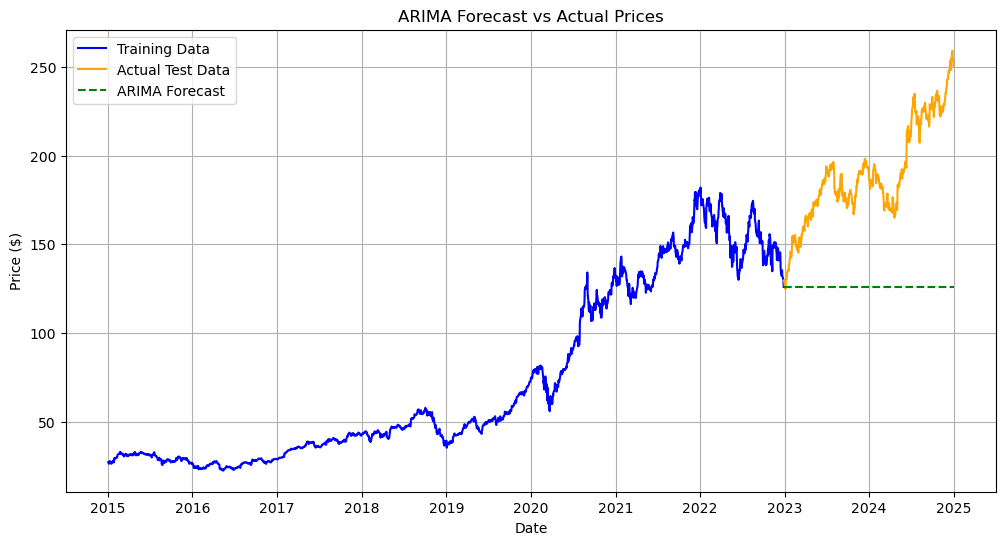

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='orange')
plt.plot(predictions.index, predictions, label='ARIMA Forecast', color='green', linestyle='--')
plt.title('ARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
"""
GARCH մոդելի կիրառումը ARIMA մոդելից ստացված մնացորդների վրա
Վոլատիլության մոդելավորում AAPL բաժնետոմսի համար
"""

'\nGARCH մոդելի կիրառումը ARIMA մոդելից ստացված մնացորդների վրա\nՎոլատիլության մոդելավորում AAPL բաժնետոմսի համար\n'

In [26]:
from arch import arch_model

In [27]:
arima_residuals = model_fit.resid

In [28]:
print("ARIMA մոդելի մնացորդները ստացված են:")
print(arima_residuals.head())
print("...")
print(arima_residuals.tail())

ARIMA մոդելի մնացորդները ստացված են:
Date
2015-01-02 00:00:00-05:00    27.332500
2015-01-05 00:00:00-05:00    -0.769996
2015-01-06 00:00:00-05:00    -0.041083
2015-01-07 00:00:00-05:00     0.370167
2015-01-08 00:00:00-05:00     1.056020
dtype: float64
...
Date
2022-12-21 00:00:00-05:00    3.138683
2022-12-22 00:00:00-05:00   -3.041770
2022-12-23 00:00:00-05:00   -0.542723
2022-12-27 00:00:00-05:00   -1.860821
2022-12-28 00:00:00-05:00   -4.095665
dtype: float64


In [29]:
#  GARCH մոդելի սահմանում և մարզում
# Մենք կօգտագործենք GARCH(1, 1) մոդելը, որը ամենատարածվածն է:
# mean='zero' քանի որ մնացորդների միջինը պետք է մոտ լինի զրոյի։
# vol='GARCH' նշանակում է GARCH մոդել
# p=1, q=1 ARCH և GARCH լագերի քանակը
# dist='normal' կամ 't' (Student's t). Ֆինանսական տվյալները հաճախ ունեն
# ավելի հաստ պոչեր, քան նորմալ բաշխումը, ուստի 't' բաշխումը կարող է ավելի լավ լինել:
# Սկսենք normal-ով:

print("\nՔայլ 2: GARCH(1, 1) մոդելի սահմանում և մարզում...")

# Սահմանել GARCH մոդելը
# 'ZeroMean' քանի որ մնացորդների միջինը պետք է մոտ լինի 0-ի


Քայլ 2: GARCH(1, 1) մոդելի սահմանում և մարզում...


In [30]:
garch_model = arch_model(arima_residuals, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')

In [31]:
# Մարզել GARCH մոդելը
garch_results = garch_model.fit(disp='off') # disp='off' անջատում է մարզման ընթացքում տպվող ինֆորմացիան

In [32]:
# GARCH մոդելի ամփոփման տպում
# Սա ցույց է տալիս գնահատված գործակիցները և թեստերը վոլատիլության հավասարման համար:

print("\nՔայլ 3: GARCH մոդելի ամփոփում")
print(garch_results.summary())


Քայլ 3: GARCH մոդելի ամփոփում
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2935.33
Distribution:                  Normal   AIC:                           5876.65
Method:            Maximum Likelihood   BIC:                           5893.47
                                        No. Observations:                 2012
Date:                Mon, Apr 28 2025   Df Residuals:                     2012
Time:                        15:27:33   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0110  3.94

In [33]:
num_test_obs = len(test_data) # Ձեր թեստային տվյալների չափը
volatility_forecast = garch_results.forecast(horizon=num_test_obs, start=0)

forecasted_variance = volatility_forecast.variance.iloc[-1].T

# Վոլատիլությունը ստանդարտ շեղումն է (քառակուսի արմատը դիսպերսիայից)
forecasted_volatility = np.sqrt(forecasted_variance)


Կանխատեսված վոլատիլությունը (պայմանական ստանդարտ շեղում):
Date
2022-12-29 00:00:00-05:00    2.925440
2022-12-30 00:00:00-05:00    2.927327
2023-01-03 00:00:00-05:00    2.929214
2023-01-04 00:00:00-05:00    2.931099
2023-01-05 00:00:00-05:00    2.932982
Name: 2022-12-28 00:00:00-05:00, dtype: float64
...
Date
2024-12-24 00:00:00-05:00    3.751054
2024-12-26 00:00:00-05:00    3.752526
2024-12-27 00:00:00-05:00    3.753998
2024-12-30 00:00:00-05:00    3.755469
2024-12-31 00:00:00-05:00    3.756940
Name: 2022-12-28 00:00:00-05:00, dtype: float64


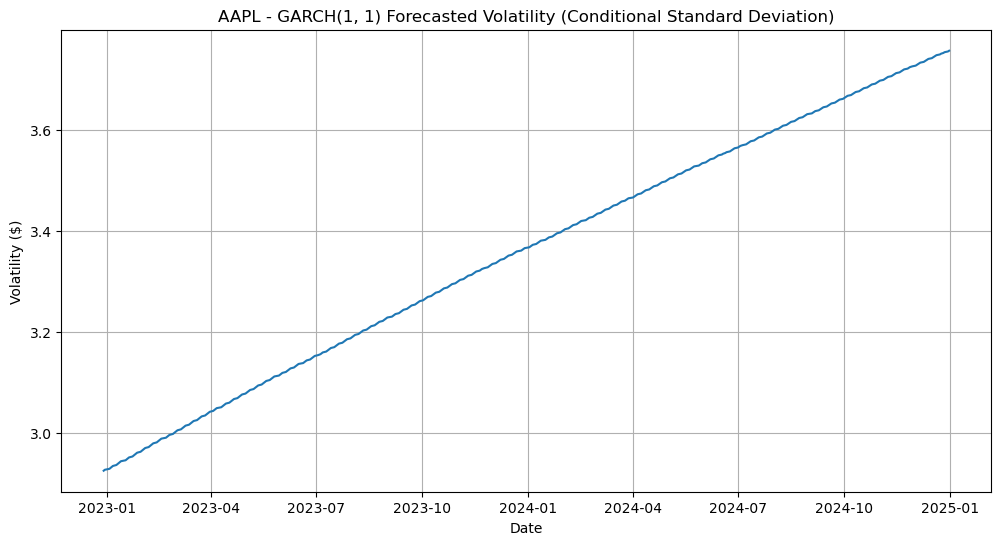


GARCH մոդելով կանխատեսումն ավարտված է:


In [37]:
try:
    forecasted_volatility.index = test_data.index

    print("\nԿանխատեսված վոլատիլությունը (պայմանական ստանդարտ շեղում):")
    print(forecasted_volatility.head())
    print("...")
    print(forecasted_volatility.tail())

    # -----------------------------------------------------------------------------
    # Քայլ 5: Վոլատիլության կանխատեսման վիզուալացում
    # Պատկերել կանխատեսված վոլատիլությունը

    plt.figure(figsize=(12, 6))
    plt.plot(forecasted_volatility.index, forecasted_volatility)
    plt.title('AAPL - GARCH(1, 1) Forecasted Volatility (Conditional Standard Deviation)')
    plt.xlabel('Date')
    plt.ylabel('Volatility ($)')
    plt.grid(True)
    plt.show()


except NameError:
    print("\nՎիզուալացումը հնարավոր չէ, քանի որ 'test_data' օբյեկտը կամ դրա ինդեքսները հասանելի չեն։")
    print("Խնդրում ենք համոզվել, որ 'test_data' փոփոխականը սահմանված է։")
    print("Կանխատեսված վոլատիլության արժեքները:")
    print(forecasted_volatility)


print("\nGARCH մոդելով կանխատեսումն ավարտված է:")